<b>1. Introduction</b><br>
<p> Unsupervised learning is an Machine Learning Algorithm which is used to find patterns and similarity between samples in data. K-Means is an Unsupervised learning algorithm that helps finding patterns in Convex Sets of data</p>
<p> Foursquare is a social networking service that allows people to finding attractions, leaving reviews and connect with friends. In this study, Foursquare is used to exctract venues in two neigborhoods in Calgary, Canada and the aim is to compare both venues and comitted crime in thsese two neighborhoods. Indeed, when a person wants to start a new business in a location, <br>having venues and crime count</br> in that location helps as a guide to choose a location for a new business to be started.
 </p>

<b>2. Data</b><br>
<p>In this study, Calgary Crime Data was downloaded from https://data.calgary.ca. The data was filtered and downtown and east neighborhoods and their respective location in longitude and latitude coordinates were taking into account. After having longitude and latitude coordinates of neighborhoods, the Foursquare API is used to extract venues in both locations. The API sent a GET request to adquire the venues that are within a radius of 500m. The venues then were formated using one hot encoding and were grouped by neighborhoods computing the mean of each feature. The frequency of the categories found in the neighborhoods was used to find the similarities. The similarities were an important element to help a user to choose a location for a new business.</p>

<b>3. Methodology</b><br>
<p>As it mentioned before, One Hot Encoding is used for feature extraction of categories. To indicate each feature as a category that belongs to a venue, each feature becomes binary. In other words, 1 shows that the category is found in the venue and 0 means that the category is not found in the venue. In the next step, all the venues are grouped by the neighborhoods and the mean which results in calculating the frequency of occurrence of that particular category.

In order to find similarities between neighborhoods, a clustering algorithm, specifically K-Means was implemented.
K-Means is a clustering algorithm that search clusters within the data to minimize the data dispersion for each cluster. 

To find a proper the number of clusters the elbow method was implemented and used. After indicating the number of cluster each cluster was analyzed seperately.</p>

<b>3. Results </b><br>
<p>After clustering data, the result may help people to start a business in a location. Commited crimes in a particular location has an important effect in terms of saftety for a new business to be started. For instance, in Calgary, downtown is a active business location but on the other hand it is unsafe in terms of crimes. Cluster one in downtwon has multiple active businesses including pharmacy, restaurant, gas station, school, supermarket, coffee shop, baseball stadium, pool, bank and etc. The most crime has been comitted in this area with the number of 260679 out of 268014 since 2012 which is huge and it might be helpful to have it considered. On the contrast, the active business location of east side of Calgary is cluster two, with 57717 number of crimes out of 67704 since 2012. </p>

<h2>1. Import important libraries<h2>

In [1]:
#!conda install -c conda-forge geopy --yes
import numpy as np
import pandas as pd 
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import folium 
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist 
from sklearn import datasets
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values


print('Libraries imported.')

Libraries imported.


<h2>2. Import data from Foursquare<h2>

In [2]:
df = pd.read_csv("CommunityCrimeFilteredNonDropped.csv")

In [3]:
df.shape

(40796, 11)

In [4]:
df['Lat'], df['Long'] = df['Community Center Point'].str.split(',', 1).str
df['Lat'] = df['Lat'].map(lambda x: x.lstrip('('))
df['Lat'] = pd.to_numeric(df['Lat'], errors='ignore')
df['Long'] = df['Long'].map(lambda x: x.rstrip(')'))
df['Long'] = pd.to_numeric(df['Long'], errors='ignore')

<ipython-input-4-2a5ee0d9ca3d>:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df['Lat'], df['Long'] = df['Community Center Point'].str.split(',', 1).str


In [5]:
address = 'Calgary, CA'

geolocator = Nominatim(user_agent="calgary")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Calgary are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Calgary are 51.0534234, -114.0625892.


<h4>2.1 Setting up the credentials <h4>

In [6]:
CLIENT_ID = 'TCPEPEPOL14I5M5DYQYVFER30JREYS5PPTIESIWRLVEHPCWK' # your Foursquare ID
CLIENT_SECRET = 'OWKV35RGUEGR4DDVEGYA2H55ULGX1EASVVTD41BUCRJTPUBG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TCPEPEPOL14I5M5DYQYVFER30JREYS5PPTIESIWRLVEHPCWK
CLIENT_SECRET:OWKV35RGUEGR4DDVEGYA2H55ULGX1EASVVTD41BUCRJTPUBG


In [7]:
downTown = df[df['Sector'] == 'CENTRE'].reset_index(drop=True)
west = df[df['Sector'] == 'EAST'].reset_index(drop=True)

<h4> 2.2 Create and send the GET request <h4>

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    count = 0
    results = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        count += 1
        print(count)
        print('-----')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            200)
            
        # make the GET request
        jsonBlob = requests.get(url, "none").json()
        if 'response' not in jsonBlob or 'groups' not in jsonBlob['response']:
            continue
        
        else:
            results = jsonBlob["response"]['groups'][0]['items']
            
        # return only relevant information for each nearby venue
        venues_list.append([(
                name,
                j['venue']['name'], 
                j['venue']['location']['lat'], 
                j['venue']['location']['lng'],  
                j['venue']['categories'][0]['name']) for j in results])
    
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<h5>2.1.1 Downtown Venues <h5>

In [9]:
# downTownVenues = getNearbyVenues(names= downTown['Community Name'],
#                                  latitudes=downTown['Lat'],
#                                    longitudes=downTown['Long'])

In [10]:
# downTownVenues.to_csv("downTown.csv", index=False)

<h5>2.1.2 East Venues <h5>

In [11]:
# eastVenues = getNearbyVenues(names = east['Community Name'],
#                                  latitudes = east['Lat'],
#                                    longitudes = east['Long'])

In [12]:
# eastVenues.to_csv("east.csv", index=False)

 <h4> 2.1.3 Calculate total crime in each neighborhood <h4>

In [13]:
def preProcessing(df, sector):
    
    result = df[df['Sector'] == sector].reset_index(drop=True)
    
    result['Total Crime Count'] = result['Crime Count'].groupby(result['Community Name']).transform('sum')
    result = result.groupby('Community Name').first()
    
    result['Lat'], result['Long'] = result['Community Center Point'].str.split(',', 1).str
    result['Lat'] = result['Lat'].map(lambda x: x.lstrip('('))
    result['Lat'] = pd.to_numeric(result['Lat'], errors='ignore')
    result['Long'] = result['Long'].map(lambda x: x.rstrip(')'))
    result['Long'] = pd.to_numeric(result['Long'], errors='ignore')
    
    result = result.sort_values(by=['Crime Count'], ascending=False)
    
    result = result.drop(['Community Center Point', 'ID', 'Date', 'Month', 'Group Category', 'Crime Count'], 1)

    return result

<h4> 2.3 One hot encoding and grouping by neighborhoods <h4>

In [14]:
def process(df):
    df_onehot = pd.get_dummies(df[['Venue Category']], prefix="", prefix_sep="")

    # add neighborhood column back to dataframe
    df_onehot['Neighborhood'] = df['Neighborhood'] 

    # move neighborhood column to the first column
    fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
    df_onehot = df_onehot[fixed_columns]
    df_grouped = df_onehot.groupby('Neighborhood').mean().reset_index()
    
    return df_grouped


In [15]:
def most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [16]:
def top_venues(df):
    
    num_top_venues = 10
    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['Neighborhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
    neighborhoods_venues_sorted['Neighborhood'] = df['Neighborhood']

    for ind in np.arange(df.shape[0]):
        neighborhoods_venues_sorted.iloc[ind, 1:] = most_common_venues(df.iloc[ind, :], num_top_venues)

    return neighborhoods_venues_sorted

In [17]:
downTown = pd.read_csv("downTown.csv") 
downTown = downTown.drop_duplicates()
downTown.head()

,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category
0,MOUNT PLEASANT,The Block,51.073442,-114.072149,Restaurant
1,MOUNT PLEASANT,4th Spot Kitchen & Bar,51.075881,-114.071181,Gastropub
2,MOUNT PLEASANT,7-Eleven,51.073940,-114.072048,Convenience Store
3,MOUNT PLEASANT,Mt Pleasant Arena,51.073168,-114.075205,Hockey Arena
4,MOUNT PLEASANT,Gogi Korean Barbecue,51.072992,-114.071341,Korean Restaurant


In [18]:
downTownCrimeData = preProcessing(df, 'CENTRE')
downTownCrimeData

<ipython-input-13-f6f581196b4c>:8: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  result['Lat'], result['Long'] = result['Community Center Point'].str.split(',', 1).str


,Sector,Category,Resident Count,Year,Lat,Long,Total Crime Count
Community Name,,,,,,,
BELTLINE,CENTRE,Social Disorder,25129,2019,51.037438,-114.055189,57692
DOWNTOWN COMMERCIAL CORE,CENTRE,Social Disorder,8683,2019,51.047270,-114.069592,46676
BRIDGELAND/RIVERSIDE,CENTRE,Social Disorder,6835,2019,51.050567,-114.035072,8555
TUXEDO PARK,CENTRE,Social Disorder,5326,2019,51.074245,-114.061045,4478
KILLARNEY/GLENGARRY,CENTRE,Social Disorder,7685,2019,51.030129,-114.131702,5424
MOUNT PLEASANT,CENTRE,Social Disorder,5889,2019,51.074231,-114.076028,3401
INGLEWOOD,CENTRE,Social Disorder,4024,2019,51.034141,-114.019120,3629
BANFF TRAIL,CENTRE,Social Disorder,4153,2019,51.074217,-114.115129,4563
MISSION,CENTRE,Social Disorder,4598,2019,51.033158,-114.068083,5569


In [19]:
downTown_grouped = process(downTown)
downTown_grouped.shape

(60, 165)

<h5> Top ten venues <h5>

In [20]:
neighborhoods_venues_sorted = top_venues(downTown_grouped)
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ALTADORE,Dog Run,Pub,Massage Studio,Ice Cream Shop,Playground,Spa,Food Truck,Gift Shop,Gastropub,Gas Station
1,ALYTH/BONNYBROOK,Auto Garage,Yoga Studio,Food Truck,Golf Course,Gluten-free Restaurant,Gift Shop,Gastropub,Gas Station,Furniture / Home Store,Frozen Yogurt Shop
2,BANFF TRAIL,Ice Cream Shop,Baseball Stadium,Park,Coffee Shop,Seafood Restaurant,Liquor Store,Steakhouse,High School,Soccer Stadium,Pizza Place
3,BANKVIEW,Pizza Place,Lawyer,Candy Store,Grocery Store,Coffee Shop,Yoga Studio,Gift Shop,Gastropub,Gas Station,Furniture / Home Store
4,BEL-AIRE,Scenic Lookout,Clothing Store,Food Court,Gift Shop,Gastropub,Gas Station,Furniture / Home Store,Frozen Yogurt Shop,French Restaurant,Food Truck


<h3> 3. Clustering<h3>

<h4>3.1. Find centroids with K-means<h4>

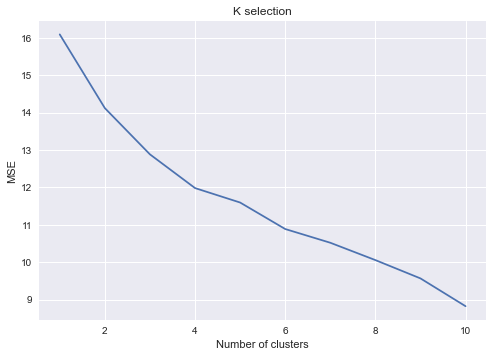

In [21]:
plt.style.use("seaborn")
Ks = 11
mse = np.zeros((Ks-1))
downTown_grouped_clustering = downTown_grouped.drop('Neighborhood', 1)
for n in range(1,Ks):
    
    # set number of clusters
    kclusters = n
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(downTown_grouped_clustering)
    mse[n-1] = kmeans.inertia_

plt.plot(range(1,Ks),mse)
plt.xlabel("Number of clusters")
plt.ylabel("MSE")
plt.title("K selection")
plt.show()

In [22]:
# set number of clusters
kclusters = 6

downTown_grouped_clustering = downTown_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(downTown_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 1, 1, 1, 1, 1, 1, 3, 1], dtype=int32)

In [23]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

downTown_merged = downTownCrimeData

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
downTown_merged = downTown_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Community Name')
downTown_merged

,Sector,Category,Resident Count,Year,Lat,Long,Total Crime Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Community Name,,,,,,,,,,,,,,,,,,
BELTLINE,CENTRE,Social Disorder,25129,2019,51.037438,-114.055189,57692,1,Pharmacy,Bakery,Comedy Club,Restaurant,Sports Bar,Stadium,Music Venue,Racetrack,Nightclub,New American Restaurant
DOWNTOWN COMMERCIAL CORE,CENTRE,Social Disorder,8683,2019,51.047270,-114.069592,46676,1,Restaurant,Coffee Shop,Hotel,Pub,Sandwich Place,Mediterranean Restaurant,Bar,Japanese Restaurant,Café,American Restaurant
BRIDGELAND/RIVERSIDE,CENTRE,Social Disorder,6835,2019,51.050567,-114.035072,8555,1,Sushi Restaurant,Moving Target,Italian Restaurant,Grocery Store,Deli / Bodega,Train,Gym / Fitness Center,Coffee Shop,Yoga Studio,Gas Station
TUXEDO PARK,CENTRE,Social Disorder,5326,2019,51.074245,-114.061045,4478,1,Italian Restaurant,Chinese Restaurant,Grocery Store,Pub,Tea Room,Dim Sum Restaurant,Convenience Store,Restaurant,Coffee Shop,Greek Restaurant
KILLARNEY/GLENGARRY,CENTRE,Social Disorder,7685,2019,51.030129,-114.131702,5424,1,School,Pharmacy,Convenience Store,Home Service,Hobby Shop,Yoga Studio,Gastropub,Gas Station,Furniture / Home Store,Frozen Yogurt Shop
MOUNT PLEASANT,CENTRE,Social Disorder,5889,2019,51.074231,-114.076028,3401,1,Gastropub,Breakfast Spot,Restaurant,Korean Restaurant,Convenience Store,Hockey Arena,Yoga Studio,Food Truck,Gift Shop,Gas Station
INGLEWOOD,CENTRE,Social Disorder,4024,2019,51.034141,-114.019120,3629,1,Gas Station,Diner,Antique Shop,Food Truck,Golf Course,Gluten-free Restaurant,Gift Shop,Gastropub,Furniture / Home Store,Frozen Yogurt Shop
BANFF TRAIL,CENTRE,Social Disorder,4153,2019,51.074217,-114.115129,4563,1,Ice Cream Shop,Baseball Stadium,Park,Coffee Shop,Seafood Restaurant,Liquor Store,Steakhouse,High School,Soccer Stadium,Pizza Place
MISSION,CENTRE,Social Disorder,4598,2019,51.033158,-114.068083,5569,1,Bakery,Coffee Shop,French Restaurant,Gym / Fitness Center,Yoga Studio,Sporting Goods Shop,Beer Garden,Breakfast Spot,Burger Joint,Café


<h4> 3.2 Displaying clusters on map <h4>

In [24]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(downTown_merged['Lat'], downTown_merged['Long'], downTown_merged['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h4>4.3. Analyze Centroids<h4>

In [25]:
downTown_merged.loc[downTown_merged['Cluster Labels'] == 0, downTown_merged.columns[[1] + list(range(5, downTown_merged.shape[1]))]]

,Category,Long,Total Crime Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Community Name,,,,,,,,,,,,,,
ALYTH/BONNYBROOK,Social Disorder,-114.022482,1303,0,Auto Garage,Yoga Studio,Food Truck,Golf Course,Gluten-free Restaurant,Gift Shop,Gastropub,Gas Station,Furniture / Home Store,Frozen Yogurt Shop
SCARBORO/ SUNALTA WEST,Social Disorder,-114.114859,331,0,Moving Target,Auto Garage,Yoga Studio,Food Truck,Gluten-free Restaurant,Gift Shop,Gastropub,Gas Station,Furniture / Home Store,Frozen Yogurt Shop


In [26]:
downTown_merged.loc[downTown_merged['Cluster Labels'] == 1, downTown_merged.columns[[1] + list(range(5, downTown_merged.shape[1]))]]

,Category,Long,Total Crime Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Community Name,,,,,,,,,,,,,,
BELTLINE,Social Disorder,-114.055189,57692,1,Pharmacy,Bakery,Comedy Club,Restaurant,Sports Bar,Stadium,Music Venue,Racetrack,Nightclub,New American Restaurant
DOWNTOWN COMMERCIAL CORE,Social Disorder,-114.069592,46676,1,Restaurant,Coffee Shop,Hotel,Pub,Sandwich Place,Mediterranean Restaurant,Bar,Japanese Restaurant,Café,American Restaurant
BRIDGELAND/RIVERSIDE,Social Disorder,-114.035072,8555,1,Sushi Restaurant,Moving Target,Italian Restaurant,Grocery Store,Deli / Bodega,Train,Gym / Fitness Center,Coffee Shop,Yoga Studio,Gas Station
TUXEDO PARK,Social Disorder,-114.061045,4478,1,Italian Restaurant,Chinese Restaurant,Grocery Store,Pub,Tea Room,Dim Sum Restaurant,Convenience Store,Restaurant,Coffee Shop,Greek Restaurant
KILLARNEY/GLENGARRY,Social Disorder,-114.131702,5424,1,School,Pharmacy,Convenience Store,Home Service,Hobby Shop,Yoga Studio,Gastropub,Gas Station,Furniture / Home Store,Frozen Yogurt Shop
MOUNT PLEASANT,Social Disorder,-114.076028,3401,1,Gastropub,Breakfast Spot,Restaurant,Korean Restaurant,Convenience Store,Hockey Arena,Yoga Studio,Food Truck,Gift Shop,Gas Station
INGLEWOOD,Social Disorder,-114.019120,3629,1,Gas Station,Diner,Antique Shop,Food Truck,Golf Course,Gluten-free Restaurant,Gift Shop,Gastropub,Furniture / Home Store,Frozen Yogurt Shop
BANFF TRAIL,Social Disorder,-114.115129,4563,1,Ice Cream Shop,Baseball Stadium,Park,Coffee Shop,Seafood Restaurant,Liquor Store,Steakhouse,High School,Soccer Stadium,Pizza Place
MISSION,Social Disorder,-114.068083,5569,1,Bakery,Coffee Shop,French Restaurant,Gym / Fitness Center,Yoga Studio,Sporting Goods Shop,Beer Garden,Breakfast Spot,Burger Joint,Café


<h4> Total Crime Count in cluster one: <h4>

In [27]:
downTown_merged.loc[downTown_merged['Cluster Labels'] == 1, 'Total Crime Count'].sum()

260679

In [28]:
downTown_merged['Total Crime Count'].sum()

268014

In [29]:
downTown_merged.loc[downTown_merged['Cluster Labels'] == 2, downTown_merged.columns[[1] + list(range(5, downTown_merged.shape[1]))]]

,Category,Long,Total Crime Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Community Name,,,,,,,,,,,,,,
RIDEAU PARK,Social Disorder,-114.074161,273,2,Park,Golf Course,Gift Shop,Gastropub,Gas Station,Furniture / Home Store,Frozen Yogurt Shop,French Restaurant,Food Truck,Food Court
UPPER MOUNT ROYAL,Physical Disorder,-114.085028,1286,2,Park,Athletics & Sports,Food Court,Gluten-free Restaurant,Gift Shop,Gastropub,Gas Station,Furniture / Home Store,Frozen Yogurt Shop,French Restaurant
ELBOYA,Physical Disorder,-114.073620,996,2,Park,Golf Course,Gift Shop,Gastropub,Gas Station,Furniture / Home Store,Frozen Yogurt Shop,French Restaurant,Food Truck,Food Court


In [30]:
downTown_merged.loc[downTown_merged['Cluster Labels'] == 3, downTown_merged.columns[[1] + list(range(5, downTown_merged.shape[1]))]]

,Category,Long,Total Crime Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Community Name,,,,,,,,,,,,,,
BURNS INDUSTRIAL,Social Disorder,-114.039686,812,3,Furniture / Home Store,Yoga Studio,Gourmet Shop,Gluten-free Restaurant,Gift Shop,Gastropub,Gas Station,Frozen Yogurt Shop,French Restaurant,Food Truck


In [31]:
downTown_merged.loc[downTown_merged['Cluster Labels'] == 4, downTown_merged.columns[[1] + list(range(5, downTown_merged.shape[1]))]]

,Category,Long,Total Crime Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Community Name,,,,,,,,,,,,,,
ERLTON,Social Disorder,-114.063147,1211,4,Breakfast Spot,Yoga Studio,French Restaurant,Golf Course,Gluten-free Restaurant,Gift Shop,Gastropub,Gas Station,Furniture / Home Store,Frozen Yogurt Shop


In [32]:
downTown_merged.loc[downTown_merged['Cluster Labels'] == 5, downTown_merged.columns[[1] + list(range(5, downTown_merged.shape[1]))]]

,Category,Long,Total Crime Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Community Name,,,,,,,,,,,,,,
HIGHWOOD,Social Disorder,-114.079901,1123,5,Bakery,Yoga Studio,Food Truck,Golf Course,Gluten-free Restaurant,Gift Shop,Gastropub,Gas Station,Furniture / Home Store,Frozen Yogurt Shop


In [33]:
southEast = pd.read_csv("east.csv") 

In [34]:
east = pd.read_csv("east.csv") 
east = east.drop_duplicates()
east.head()

,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category
0,PENBROOKE MEADOWS,Blue Electrical Services & Technology,51.047145,-113.948472,Construction & Landscaping
1,PENBROOKE MEADOWS,C&C Hauling,51.042490,-113.944358,Business Service
2,PENBROOKE MEADOWS,Royal Canadian Fried Chicken,51.048209,-113.953608,Fried Chicken Joint
3,FOREST LAWN,Dairy Queen,51.037465,-113.968082,Ice Cream Shop
4,FOREST LAWN,Indonesian Kitchen,51.037683,-113.977513,Indonesian Restaurant


In [35]:
eastCrimeData = preProcessing(df, 'EAST')

<ipython-input-13-f6f581196b4c>:8: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  result['Lat'], result['Long'] = result['Community Center Point'].str.split(',', 1).str


In [36]:
eastCrimeData.drop(eastCrimeData.loc[eastCrimeData['Resident Count'] == 0].index, inplace=True)

In [37]:
eastCrimeData

,Sector,Category,Resident Count,Year,Lat,Long,Total Crime Count
Community Name,,,,,,,
FOREST LAWN,EAST,Social Disorder,7814,2019,51.037848,-113.971230,18556
DOVER,EAST,Social Disorder,10351,2019,51.022463,-113.993151,10010
ALBERT PARK/RADISSON HEIGHTS,EAST,Social Disorder,6997,2019,51.044541,-113.996784,9306
PENBROOKE MEADOWS,EAST,Social Disorder,8554,2019,51.045866,-113.947516,7328
ERIN WOODS,EAST,Social Disorder,7049,2019,51.021051,-113.967607,3522
SOUTHVIEW,EAST,Social Disorder,1805,2019,51.034156,-113.997338,4576
FOREST LAWN INDUSTRIAL,EAST,Social Disorder,123,2019,51.027111,-113.956970,2585
RED CARPET,EAST,Social Disorder,1594,2019,51.042514,-113.938773,1270
10A,EAST,Social Disorder,648,2012,51.052305,-113.893029,486


In [38]:
east_grouped = process(east)
east_grouped.shape

(18, 47)

In [39]:
neighborhoods_venues_sorted_east = top_venues(east_grouped)
neighborhoods_venues_sorted_east.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,09H,Golf Course,Food Truck,Vietnamese Restaurant,Convenience Store,Gas Station,Furniture / Home Store,Fried Chicken Joint,Food Service,Fast Food Restaurant,Diner
1,09P,Food Service,Vietnamese Restaurant,Convenience Store,Golf Course,Gas Station,Furniture / Home Store,Fried Chicken Joint,Food Truck,Fast Food Restaurant,Diner
2,10C,Food Service,Vietnamese Restaurant,Convenience Store,Golf Course,Gas Station,Furniture / Home Store,Fried Chicken Joint,Food Truck,Fast Food Restaurant,Diner
3,ALBERT PARK/RADISSON HEIGHTS,Vietnamese Restaurant,Light Rail Station,Home Service,Train Station,Bar,Baseball Field,Gas Station,Athletics & Sports,Furniture / Home Store,Fried Chicken Joint
4,APPLEWOOD PARK,Trail,Home Service,Park,Liquor Store,Construction & Landscaping,Vietnamese Restaurant,Convenience Store,Furniture / Home Store,Fried Chicken Joint,Food Truck


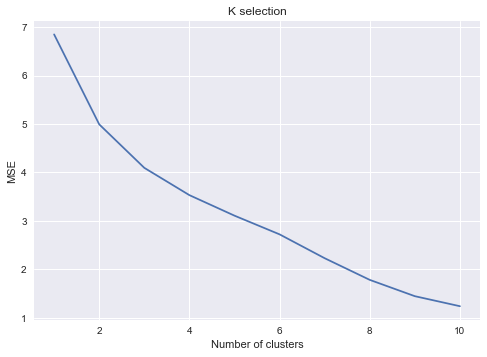

In [40]:
plt.style.use("seaborn")
Ks = 11
mse = np.zeros((Ks-1))
downTown_grouped_clustering = east_grouped.drop('Neighborhood', 1)
for n in range(1,Ks):
    
    # set number of clusters
    kclusters = n
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(downTown_grouped_clustering)
    mse[n-1] = kmeans.inertia_

plt.plot(range(1,Ks),mse)
plt.xlabel("Number of clusters")
plt.ylabel("MSE")
plt.title("K selection")
plt.show()

In [41]:
# set number of clusters
kclusters = 3

east_grouped_clustering = east_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(east_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 0, 0, 2, 1, 2, 1, 2, 2, 2], dtype=int32)

In [42]:
# add clustering labels
neighborhoods_venues_sorted_east.insert(0, 'Cluster Labels', kmeans.labels_)

east_merged = eastCrimeData

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
east_merged = east_merged.join(neighborhoods_venues_sorted_east.set_index('Neighborhood'), on='Community Name')
east_merged = east_merged[east_merged['Cluster Labels'].notna()]

In [43]:
east_merged

,Sector,Category,Resident Count,Year,Lat,Long,Total Crime Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Community Name,,,,,,,,,,,,,,,,,,
FOREST LAWN,EAST,Social Disorder,7814,2019,51.037848,-113.971230,18556,2.0,Vietnamese Restaurant,Pizza Place,Ice Cream Shop,Indonesian Restaurant,Fast Food Restaurant,Mediterranean Restaurant,Department Store,Convenience Store,Chinese Restaurant,Grocery Store
DOVER,EAST,Social Disorder,10351,2019,51.022463,-113.993151,10010,2.0,Home Service,Baseball Field,Playground,Diner,Vietnamese Restaurant,Convenience Store,Gas Station,Furniture / Home Store,Fried Chicken Joint,Food Truck
ALBERT PARK/RADISSON HEIGHTS,EAST,Social Disorder,6997,2019,51.044541,-113.996784,9306,2.0,Vietnamese Restaurant,Light Rail Station,Home Service,Train Station,Bar,Baseball Field,Gas Station,Athletics & Sports,Furniture / Home Store,Fried Chicken Joint
PENBROOKE MEADOWS,EAST,Social Disorder,8554,2019,51.045866,-113.947516,7328,1.0,Construction & Landscaping,Fried Chicken Joint,Business Service,Convenience Store,Golf Course,Gas Station,Furniture / Home Store,Food Truck,Food Service,Fast Food Restaurant
ERIN WOODS,EAST,Social Disorder,7049,2019,51.021051,-113.967607,3522,2.0,Park,Health Food Store,Construction & Landscaping,Gas Station,Furniture / Home Store,Fried Chicken Joint,Food Truck,Food Service,Fast Food Restaurant,Diner
SOUTHVIEW,EAST,Social Disorder,1805,2019,51.034156,-113.997338,4576,2.0,Golf Course,Bus Station,National Park,Convenience Store,Gas Station,Furniture / Home Store,Fried Chicken Joint,Food Truck,Food Service,Fast Food Restaurant
FOREST LAWN INDUSTRIAL,EAST,Social Disorder,123,2019,51.027111,-113.956970,2585,2.0,Convenience Store,Liquor Store,Vietnamese Restaurant,Gas Station,Furniture / Home Store,Fried Chicken Joint,Food Truck,Food Service,Fast Food Restaurant,Diner
RED CARPET,EAST,Social Disorder,1594,2019,51.042514,-113.938773,1270,2.0,Vietnamese Restaurant,Tea Room,Bar,Business Service,Convenience Store,Gas Station,Furniture / Home Store,Fried Chicken Joint,Food Truck,Food Service
10C,EAST,Physical Disorder,171,2012,51.026955,-113.888657,86,0.0,Food Service,Vietnamese Restaurant,Convenience Store,Golf Course,Gas Station,Furniture / Home Store,Fried Chicken Joint,Food Truck,Fast Food Restaurant,Diner


In [44]:
east_merged['Cluster Labels'] = east_merged['Cluster Labels'].astype(int)

In [45]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(east_merged['Lat'], east_merged['Long'], east_merged['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [46]:
east_merged.loc[east_merged['Cluster Labels'] == 0, east_merged.columns[[1] + list(range(5, east_merged.shape[1]))]]

,Category,Long,Total Crime Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Community Name,,,,,,,,,,,,,,
10C,Physical Disorder,-113.888657,86,0,Food Service,Vietnamese Restaurant,Convenience Store,Golf Course,Gas Station,Furniture / Home Store,Fried Chicken Joint,Food Truck,Fast Food Restaurant,Diner
09P,Social Disorder,-113.888657,2,0,Food Service,Vietnamese Restaurant,Convenience Store,Golf Course,Gas Station,Furniture / Home Store,Fried Chicken Joint,Food Truck,Fast Food Restaurant,Diner


In [47]:
east_merged.loc[east_merged['Cluster Labels'] == 1, east_merged.columns[[1] + list(range(5, east_merged.shape[1]))]]

,Category,Long,Total Crime Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Community Name,,,,,,,,,,,,,,
PENBROOKE MEADOWS,Social Disorder,-113.947516,7328,1,Construction & Landscaping,Fried Chicken Joint,Business Service,Convenience Store,Golf Course,Gas Station,Furniture / Home Store,Food Truck,Food Service,Fast Food Restaurant
APPLEWOOD PARK,Physical Disorder,-113.927858,2571,1,Trail,Home Service,Park,Liquor Store,Construction & Landscaping,Vietnamese Restaurant,Convenience Store,Furniture / Home Store,Fried Chicken Joint,Food Truck


In [48]:
east_merged.loc[east_merged['Cluster Labels'] == 2, east_merged.columns[[1] + list(range(5, east_merged.shape[1]))]]

,Category,Long,Total Crime Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Community Name,,,,,,,,,,,,,,
FOREST LAWN,Social Disorder,-113.971230,18556,2,Vietnamese Restaurant,Pizza Place,Ice Cream Shop,Indonesian Restaurant,Fast Food Restaurant,Mediterranean Restaurant,Department Store,Convenience Store,Chinese Restaurant,Grocery Store
DOVER,Social Disorder,-113.993151,10010,2,Home Service,Baseball Field,Playground,Diner,Vietnamese Restaurant,Convenience Store,Gas Station,Furniture / Home Store,Fried Chicken Joint,Food Truck
ALBERT PARK/RADISSON HEIGHTS,Social Disorder,-113.996784,9306,2,Vietnamese Restaurant,Light Rail Station,Home Service,Train Station,Bar,Baseball Field,Gas Station,Athletics & Sports,Furniture / Home Store,Fried Chicken Joint
ERIN WOODS,Social Disorder,-113.967607,3522,2,Park,Health Food Store,Construction & Landscaping,Gas Station,Furniture / Home Store,Fried Chicken Joint,Food Truck,Food Service,Fast Food Restaurant,Diner
SOUTHVIEW,Social Disorder,-113.997338,4576,2,Golf Course,Bus Station,National Park,Convenience Store,Gas Station,Furniture / Home Store,Fried Chicken Joint,Food Truck,Food Service,Fast Food Restaurant
FOREST LAWN INDUSTRIAL,Social Disorder,-113.956970,2585,2,Convenience Store,Liquor Store,Vietnamese Restaurant,Gas Station,Furniture / Home Store,Fried Chicken Joint,Food Truck,Food Service,Fast Food Restaurant,Diner
RED CARPET,Social Disorder,-113.938773,1270,2,Vietnamese Restaurant,Tea Room,Bar,Business Service,Convenience Store,Gas Station,Furniture / Home Store,Fried Chicken Joint,Food Truck,Food Service
FOREST HEIGHTS,Physical Disorder,-113.968772,5667,2,Bank,Skating Rink,Vietnamese Restaurant,Convenience Store,Gas Station,Furniture / Home Store,Fried Chicken Joint,Food Truck,Food Service,Fast Food Restaurant
FOOTHILLS,Physical Disorder,-113.981989,2225,2,Vietnamese Restaurant,Taco Place,Sandwich Place,Japanese Restaurant,Paper / Office Supplies Store,Construction & Landscaping,Furniture / Home Store,Fried Chicken Joint,Food Truck,Food Service


In [49]:
east_merged.loc[east_merged['Cluster Labels'] == 2, 'Total Crime Count'].sum()

57717

In [50]:
east_merged['Total Crime Count'].sum()

67704